# Compose stimuli from components

Most visual stimuli consist of multiple geometric elements combined together.
For example, a Gabor is a composition of a sinusoidal grating and a Gaussian envelope.

```{note}
Many common stimulus compositions are already implemented in {py:mod}`stimupy.stimuli` (checkerboards, Gabors, plaids, etc.). The methods in this guide are primarily for when you need to create custom compositions that aren't available as pre-built functions.
```

This guide shows you different ways to compose stimuli from the basic geometric {py:mod}`components <stimupy.components>` that `stimupy` provides.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from stimupy.utils import plot_stim, plot_stimuli
from stimupy.components import shapes

## Method 1: Direct composition functions

**When to use:** For common patterns where `stimupy` provides dedicated functions. **Start here** - check if your desired composition already exists before building from scratch.

**Available types:**
- Geometric patterns: {py:func}`stimupy.components.radials.rings`, {py:func}`stimupy.components.angulars.segments`, {py:func}`stimupy.components.frames.frames`
- Complete stimuli: {py:mod}`stimupy.stimuli.gratings`, {py:mod}`stimupy.stimuli.checkerboards`, etc.

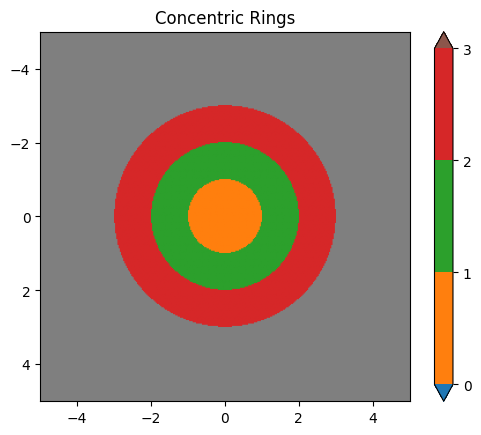

In [2]:
from stimupy.components.radials import rings
from stimupy.stimuli.gratings import on_grating
from stimupy.stimuli.plaids import sine_waves as plaid_sine

# Example 1: Concentric rings (geometric components)
visual_size = (10, 10)
ppd = 32

ring_stim = rings(visual_size=visual_size, ppd=ppd,
                  radii=(1, 2, 3),
                  intensity_rings=(0.2, 0.8, 0.4),
                  intensity_background=0.5)

plot_stim(ring_stim, mask="ring_mask", stim_name="Concentric Rings")
plt.show()

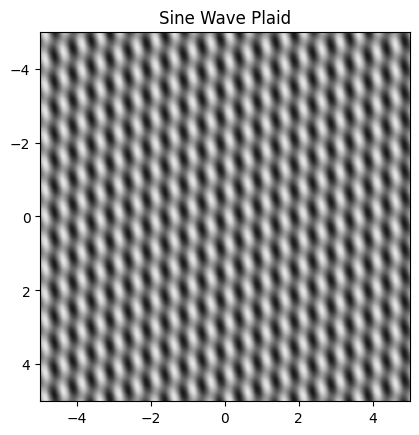

In [3]:
# Example 2: Sine wave plaid (complex composition)
grating1_params = {
    "visual_size": visual_size,
    "ppd": ppd,
    "frequency": 2,
    "intensities": (0.0, 1.0),
    "rotation": 0
}
grating2_params = {
    "visual_size": visual_size,
    "ppd": ppd,
    "frequency": 2,
    "intensities": (0.2, 0.8),
    "rotation": 45,
    "round_phase_width": False,
}

plaid_stim = plaid_sine(grating1_params, grating2_params)

plot_stim(plaid_stim, stim_name="Sine Wave Plaid")
plt.show()

/home/joris/Research/stimupy/stimupy/utils/resolution.py:350: UserWarning: Rounding shape; 4.296875 * 32.0 = 137.5 -> 137
  warnings.warn(f"Rounding shape; {visual_angle} * {ppd} = {fpix} -> {pix}")


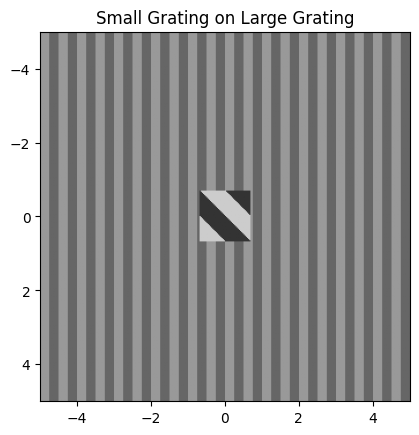

In [4]:
# Example 3: Small grating on larger grating (complete stimulus)
small_grating_params = {
    "ppd": ppd,
    "bar_width": 0.5,
    "n_bars": 4,
    "intensity_bars": (0.2, 0.8),
    "rotation": 45,
    "round_phase_width": False,
}

large_grating_params = {
    "visual_size": visual_size,
    "ppd": ppd,
    "frequency": 2,
    "intensity_bars": (0.4, 0.6),
    "rotation": 0
}

grating_stim = on_grating(small_grating_params=small_grating_params,
                         large_grating_params=large_grating_params)

plot_stim(grating_stim, stim_name="Small Grating on Large Grating")
plt.show()

## Method 2: Simple array operations

**When to use:** For basic combinations where you want to apply operations across entire images.

**Steps:**
1. Create your component stimuli
2. Apply numpy operations (addition, subtraction, multiplication) to the `"img"` arrays
3. Wrap the result in a stimulus dictionary

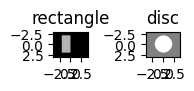

In [5]:
# Step 1: Create components
rectangle = shapes.rectangle(visual_size=(6,8), ppd=10,
                        rectangle_size=(4,2), rectangle_position=(1,2),
                        intensity_rectangle=.7)

disc = shapes.disc(visual_size=(6,8), ppd=10,
                        radius=2,
                        intensity_disc=1, intensity_background=.5)

plot_stimuli({"rectangle": rectangle, "disc": disc})
plt.show()

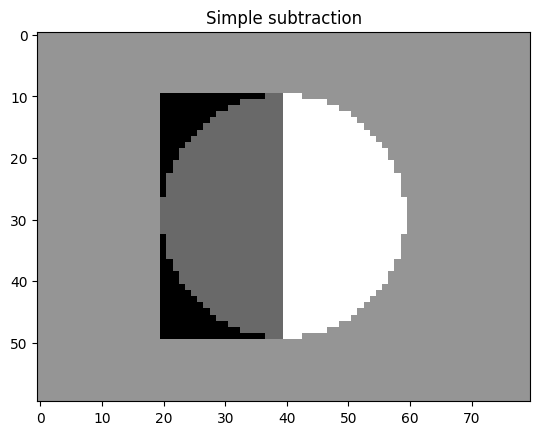

In [6]:
# Step 2: Apply operation
new_img = disc["img"] - rectangle["img"]

# Step 3: Create stimulus dictionary
composed_stim = {
    "img": new_img,
    "visual_size": disc["visual_size"],
    "ppd": disc["ppd"]
}

plt.imshow(new_img, cmap="gray")
plt.title("Simple subtraction")
plt.show()

**Limitation:** This method operates on entire images, including background regions, which may not give you the precise control you need.

## Method 3: Mask-based composition

**When to use:** When you need precise control over which regions are affected by operations.

**Steps:**
1. Create your component stimuli
2. Extract and combine the masks using logical operations
3. Use the combined mask to create your final image

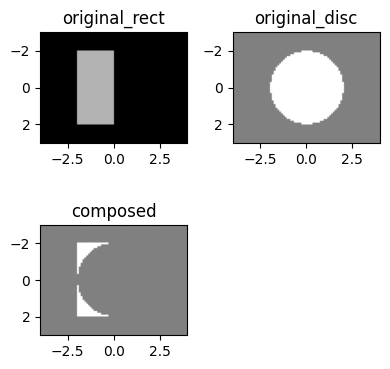

In [7]:
# Step 1: Create components (reusing from above)

# Step 2: Create logical mask combination
# Remove rectangle where it overlaps with disc
anti_join_mask = (rectangle["rectangle_mask"] == 1) & (~(disc["ring_mask"] == 1))

# Step 3: Create image using mask
composition = {
    "img": np.where(anti_join_mask, 1, .5),
    "anti_join_mask": anti_join_mask,
    "visual_size": disc["visual_size"],
    "ppd": disc["ppd"]
}

plot_stimuli({"original_rect": rectangle, "original_disc": disc, "composed": composition})

### More complex example: Dartboard

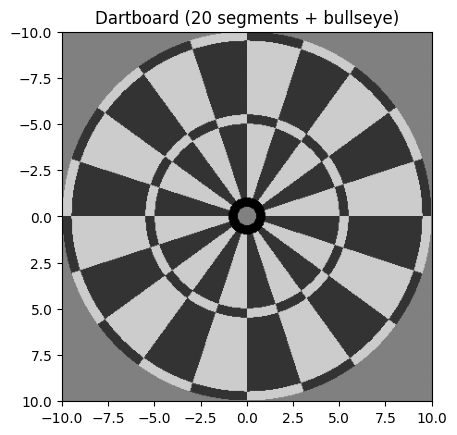

In [8]:
from stimupy.stimuli.bullseyes import circular as bullseye_circular
from stimupy.stimuli.waves import square_angular

# Create dartboard by combining angular segments (pinwheel) and concentric rings
dartboard_size = (20, 20)
dartboard_ppd = 20

# Step 1: Create a bullseye stimulus (set of concentric rings)
bullseye = bullseye_circular(visual_size=dartboard_size, ppd=dartboard_ppd,
                    n_rings=20, intensity_background=0.5)

# Step 2: Create base dartboard (segments + bullseye)
# First set of angular segments
wheel1 = square_angular(visual_size=dartboard_size, ppd=dartboard_ppd,
                       n_segments=20, intensity_segments=(0.2, 0.8))

# Step 3: Combine segments with bullseye to create base dartboard
base_dartboard_img = wheel1["img"].copy()
base_dartboard_mask = wheel1["segment_mask"].copy()

# Add bullseye in center (override segments in center area)
bullseye_center = bullseye["ring_mask"] <= 2  # inner bullseye only
base_dartboard_img = np.where(bullseye_center, bullseye["img"], base_dartboard_img)
# Keep bullseye rings in mask
base_dartboard_mask = np.where(bullseye_center, bullseye["ring_mask"], base_dartboard_mask)

# Step 4: Create opposite segments for scoring rings
wheel2 = square_angular(visual_size=dartboard_size, ppd=dartboard_ppd,
                       n_segments=20, intensity_segments=(0.8, 0.2))  # reversed intensities

# Step 5: Replace selected scoring rings with opposite pattern
# Identify specific scoring rings (e.g., rings 11 and 20)
scoring_rings = (bullseye["ring_mask"] == 11) | (bullseye["ring_mask"] == 20)

# Final dartboard: base + scoring ring replacements
dartboard_img = base_dartboard_img.copy()
dartboard_img = np.where(scoring_rings, wheel2["img"], dartboard_img)

# Final mask: combine all regions
combined_mask = base_dartboard_mask.copy()
combined_mask = np.where(scoring_rings, bullseye["ring_mask"], combined_mask)

# Step 6: Create final dartboard stimulus
dartboard = {
    "img": dartboard_img,
    "mask": combined_mask,
    "visual_size": dartboard_size,
    "ppd": dartboard_ppd
}

plot_stim(dartboard, stim_name="Dartboard (20 segments + bullseye)")
plt.show()

### Using helper functions for mask-based composition

For standard mask-based workflows, `stimupy` provides helper functions that streamline the process:

**Key functions:**
- {py:func}`stimupy.components.combine_masks`: Merge multiple masks into one indexed mask
- {py:func}`stimupy.components.draw_regions`: Draw regions based on a mask with different intensities

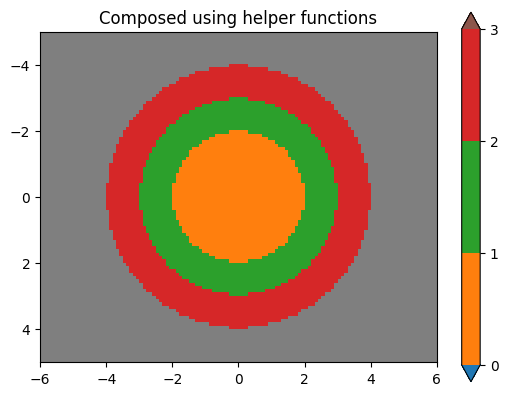

In [9]:
from stimupy.components import combine_masks, draw_regions

# Step 1: Create multiple components
visual_size = (10, 12)
ppd = 10

disc = shapes.disc(visual_size=visual_size, ppd=ppd,
                   radius=2, intensity_disc=.5, intensity_background=.5)

ring_1 = shapes.ring(visual_size=visual_size, ppd=ppd,
                     radii=(2, 3), intensity_ring=1, intensity_background=.5)

ring_2 = shapes.ring(visual_size=visual_size, ppd=ppd,
                     radii=(3, 4), intensity_ring=0, intensity_background=.5)

# Step 2: Combine masks
combined_mask = combine_masks(disc["ring_mask"], ring_1["ring_mask"], ring_2["ring_mask"])

# Step 3: Draw regions with desired intensities
img = draw_regions(mask=combined_mask, 
                   intensities=[0.5, 1, 0],  # intensities for regions 1, 2, 3
                   intensity_background=0.5)

# Step 4: Create final stimulus
bullseye = {
    "img": img,
    "mask": combined_mask,
    "visual_size": visual_size,
    "ppd": ppd
}

plot_stim(bullseye, mask="mask", stim_name="Composed using helper functions")
plt.show()

**Common mask operations:**
- Intersection: `(mask1 == 1) & (mask2 == 1)`
- Union: `(mask1 == 1) | (mask2 == 1)`
- Difference: `(mask1 == 1) & (~(mask2 == 1))`

For more details on working with masks, see the [Masks guide](masks.md).

## Choosing the right method

| Method | Best for | Pros | Cons |
|--------|----------|------|------|
| Direct functions | Common patterns | Complete solution, optimized | Only for pre-defined patterns |
| Array operations | Simple combinations | Fast, straightforward | Limited control, affects entire image |
| Mask-based | Precise region control | Fine-grained control, helper functions available | More complex setup |

## General workflow

Regardless of method, the general composition workflow is:

1. **Plan your composition**: Identify the components and how they should interact
2. **Create components**: Generate the basic geometric elements
3. **Combine appropriately**: Choose the method that best fits your needs
4. **Validate result**: Check that the composition matches your intention

The {py:mod}`stimupy.components` provide the building blocks, and these composition methods let you combine them into more complex visual stimuli.